# Decision Trees for Classification and Regression

Using decision trees for classification and regression tasks.

## Introduction

In this notebook, I am delving into the application of decision trees for both classification and regression tasks. This will by applied to data to predict whether or not a student is likely to gain admission onto a master's degree.

Decision trees are powerful models that can classify data by creating decision rules based on features. For classification, they rely on measures like Gini impurity, while for regression, they use Mean Squared Error (MSE) to assess splits and predictions. This notebook takes us through both applications, step-by-step, and showcases the nuances between using decision trees for these two distinct purposes.

## Dataset

The data contains features commonly used in determining admission to masters’ degree programmes, such as GRE, GPA, and letters of recommendation. The complete list of features is summarized below:

+ GRE Scores ( out of 340 )
+ TOEFL Scores ( out of 120 )
+ University Rating ( out of 5 )
+ Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
+ Undergraduate GPA ( out of 10 )
+ Research Experience ( either 0 or 1 )
+ Chance of Admit ( ranging from 0 to 1 )

# 1. Classification

### Data Import and Preparation: 
I'll begin by loading the dataset as a pandas DataFrame and preparing it for analysis. This includes splitting the data into training and test sets.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Admission_Predict.csv")
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

print(df.columns)

Index(['serial_no.', 'gre_score', 'toefl_score', 'university_rating', 'sop',
       'lor', 'cgpa', 'research', 'chance_of_admit'],
      dtype='object')


As a first step, I will create a binary class (1=admission likely , 0=admission unlikely) from the **chance of admit** – greater than 80% we will consider as likely. The remaining data columns will be used as predictors.

In [10]:
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']>=.8

### Fitting and Predicting

I will use scikit-learn‘s tree module to create, train, predict, and visualise a decision tree classifier. The syntax is the same as other models in scikit-learn - once an instance of the model class is instantiated with dt = DecisionTreeClassifier(), .fit() can be used to fit the model on the training set. After fitting, .predict() (and predict_proba()) and .score() can be called to generate predictions and score the model on the test data.

As with other scikit-learn models, only numeric data can be used (categorical variables and nulls must be handled prior to model fitting). In this case, our categorical features have already been transformed and no missing values are present in the data set.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01,criterion='gini')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))
print(accuracy_score(y_test, y_pred))

0.925
0.925


Two methods are available to visualise the tree within the tree module – the first is using **tree_plot** to graphically represent the decision tree. The second uses **export_text** to list the rules behind the splits in the decision tree.

|--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



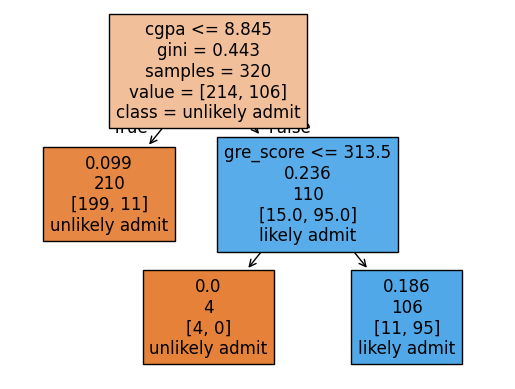

In [16]:
tree.plot_tree(dt, feature_names = x_train.columns,  
               max_depth=3, class_names = ['unlikely admit', 'likely admit'],
               label='root', filled=True)
print(tree.export_text(dt, feature_names = X.columns.tolist()))

### Split Criteria

For a classification task, the default split criteria is Gini impurity – this gives us a measure of how “impure” the groups are. At the root node, the first split is then chosen as the one that maximises the information gain, i.e. decreases the Gini impurity the most. 

Cgpa is a continuous variable, which adds an extra complication, as the split can occur for ANY value of cgpa. To verify, I will use the defined functions gini and info_gain. By running gini(y_train), we get the same Gini impurity value as printed in the tree at the root node, 0.443.

In [19]:
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)
   
gi = gini(y_train)
print(f'Gini impurity at root: {round(gi,3)}')

Gini impurity at root: 0.443


Next, we are going to verify how the split on cgpa was determined, i.e. where did the 8.845 value come from:

In [22]:
def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

We will use info_gain over ALL values of cgpa to determine the information gain when split on each value. This is stored in a table and sorted, and voila, the top value for the split is cgpa<=8.845! This is also done for every other feature (and for those continuous ones, every value), to find the top split overall.

In [25]:
info_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    info_gain_list.append([i, info_gain(left, right, gi)])

ig_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
ig_table.head(10)

,split_value,info_gain
10,8.84,0.296932
124,8.85,0.291464
139,8.88,0.290704
18,8.90,0.290054
98,8.83,0.287810
110,8.87,0.286050
152,8.94,0.284714
57,8.96,0.284210
96,8.80,0.283371
21,9.00,0.283364


Text(0, 0.5, 'info gain')

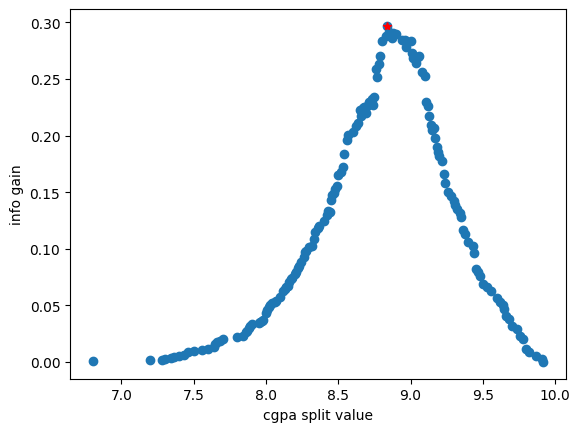

In [27]:
plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0], ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')

After this process is repeated, and there is no further info gain by splitting, the tree is finally built. Last to evaluate, any sample traverses through tree and appropriate splits until it reaches a leaf node, and then assigned the majority class of that leaf (or weighted majority).

# 2. Regression

For the regression problem, we will use the unaltered **chance_of_admit** target, which is a floating point value between 0 and 1.

In [31]:
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']

### Fitting and Predicting

The syntax is identical as the decision tree classifier, except the target, **y**, must be real-valued and the model used must be **DecisionTreeRegressor()**. As far as the model hyperparameters go, almost all are the same, except for the split criterion. The split criterion now needs be suitable for a regression task – the default for regression is **Mean Squared Error (or MSE)**. Let’s investigate this:

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
dt = DecisionTreeRegressor(max_depth=3, ccp_alpha=0.001)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.5230242793515553


Similarly, the tree can be visualised using tree.plot_tree – keeping in mind the splitting criteria is **mse** and the value is the **average chance_of_admit** of all samples in that leaf.

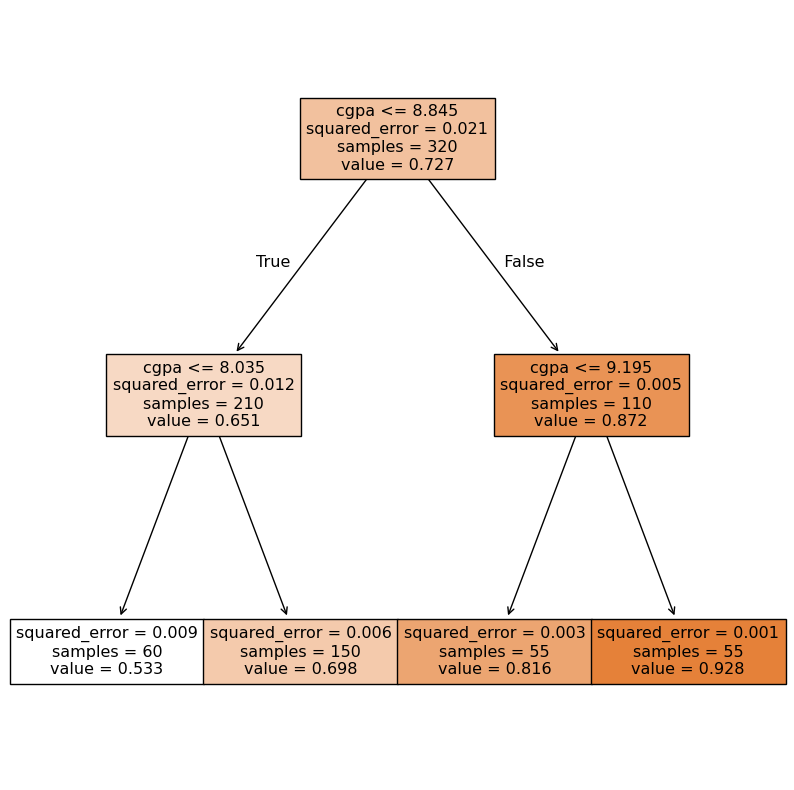

In [43]:
plt.figure(figsize=(10,10))
tree.plot_tree(dt, feature_names = x_train.columns,  
               max_depth=2, filled=True);

### Split Criteria

Unlike the classification problem, there are no longer classes to split the tree by. Instead, at each level, the value is the average of all samples that fit the logical criteria. In terms of evaluating the split, the default method is MSE. For example, the root node, the average target value is 0.727 (verify **y_train.mean()**). Then the MSE (mean-squared error) if we were to use 0.727 as the value for all samples, would be:

np.mean((y_train - y_train.mean())**2) = 0.02029

Now to determine the split, for each value of cpga, the information gain, or decrease in MSE after the split, is calculated and then values are sorted. Like before, we can modify our functions for the regression version, and see the best split is again cpga<=8.84.

The below code walks you through the details – **in the regression version, instead of Gini impurity, MSE is used, and the information gain function is modified to mse_gain**.

In [46]:
def mse(data):
    """Calculate the MSE of a data set
    """
    return np.mean((data - data.mean())**2)
   
def mse_gain(left, right, current_mse):
    """Information Gain (MSE) associated with creating a node/split data based on MSE.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_mse - w * mse(left) - (1 - w) * mse(right)

m = mse(y_train)
print(f'MSE at root: {round(m,3)}')

mse_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    mse_gain_list.append([i, mse_gain(left, right, m)])

mse_table = pd.DataFrame(mse_gain_list,columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(mse_table.head(10))

MSE at root: 0.021
     split_value  info_gain
10          8.84   0.011065
96          8.80   0.011037
98          8.83   0.011023
124         8.85   0.010985
125         8.73   0.010939
110         8.87   0.010932
139         8.88   0.010895
1           8.70   0.010894
17          8.76   0.010858
140         8.74   0.010850


Text(0, 0.5, 'info gain')

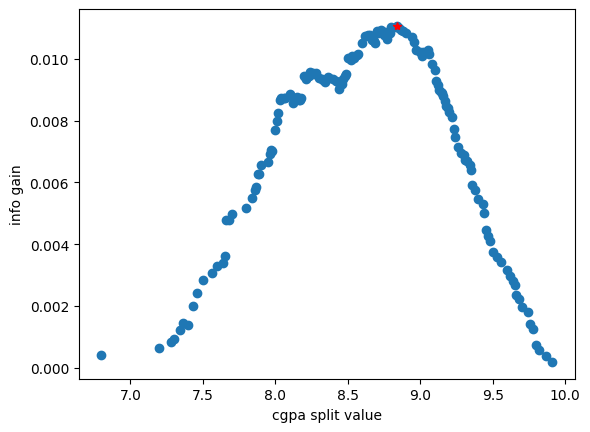

In [48]:
plt.plot(mse_table['split_value'], mse_table['info_gain'],'o')
plt.plot(mse_table['split_value'].iloc[0], mse_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')

Again, the process will continue until there is no increase in information gain by splitting. Now that the tree has been built, evaluation occurs in pretty much the same way. Any sample traverses through the tree until it reaches a leaf node and is then assigned the average value of the samples in leaf. *Depending on the depth of the tree, the predicted values can be limited*. In this example, only four unique predicted values are possible, which we can verify. This is something to be aware of when using a decision tree regressor, unlike linear/logistic regression, not all output values may be possible.

In [51]:
np.unique(dt.predict(x_train))

array([0.53283333, 0.6976    , 0.81618182, 0.92781818])

# Summary

We’ve seen how decision trees can be used for both classification and regression tasks.

+ The fundamental difference is that for classification, splits are based on Gini impurity error calculations whereas for regression, Mean Squared Error minimization is used.
+ Tree traversal based on information gain and evaluation works pretty much the same way for both tasks.
+ Decision tree regressors differ from other regressors in that all output values may not be possible and it depends on the depth of the tree.